# Classification Task: KNN
I will be building off of the mini-projct and build out a KNN classifier.

In [9]:
import pandas as pd
import numpy as np
import os
# import matplotlib.pyplot as plt
import warnings
import sklearn
# import seaborn as sns
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import preprocessing
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot

In [2]:
path = "/home/kyle/Documents/thomaskh522@gmail.com/SMU/DataMining/Classificaiton2/"
scada =  pd.read_csv(path + "SCADAcombined2017_T014.csv")
alarms_desc = pd.read_csv(path + "Siemens_Fault_Code_Descriptions.csv")
print("DF scada is: ", scada.shape)
scada.head()

DF scada is:  (52462, 1291)


,TimeStamp,StationId,wtc_VoltPhR_min,wtc_VoltPhR_max,wtc_VoltPhR_mean,wtc_VoltPhR_stddev,wtc_VoltPhS_min,wtc_VoltPhS_max,wtc_VoltPhS_mean,wtc_VoltPhS_stddev,...,wtc_TLC_SpeedRed_min,wtc_TLC_SpeedRed_max,wtc_TLC_SpeedRed_mean,wtc_TLC_SpeedRed_stddev,wtc_TLC_DeltaDay_min,wtc_TLC_DeltaDay_max,wtc_TLC_DeltaDay_mean,wtc_TLC_DeltaDay_stddev,wtc_OrStpDat_Status_endvalue,wtc_OrStpDat_LampStat_endvalue
0,2017-01-01 00:00:00.000,2308974,399.3,402.4,400.4424,0.333343,399.4,402.0,400.7586,0.287372,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
1,2017-01-01 00:10:00.000,2308974,398.2,401.2,399.2965,0.427948,397.8,401.0,399.6236,0.450038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
2,2017-01-01 00:20:00.000,2308974,397.7,400.0,398.5997,0.283229,397.4,399.7,398.7689,0.277164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
3,2017-01-01 00:30:00.000,2308974,397.8,400.4,398.7805,0.315703,397.7,400.1,399.0097,0.317276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.
4,2017-01-01 00:40:00.000,2308974,398.1,400.5,399.1493,0.326358,397.8,400.2,399.4183,0.313926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,NotInst.


### Cleaning data and some feature engineering
This code is all borrowed from the mini-project. The goal is to recreate the dataset as it was in the mini-project, but for the entire year. There was some missing and infinite data in the dataset. These values were transformed into NaN and dropped.

In [3]:
scada.dropna(thresh=10000,axis=1,inplace=True)

colsdrop = ['StationId', 'CommunicationId', 'NeighbourId',
           'NeighbourIdTwo', 'XPos', 'YPos', 'wtc_ActPower_min',
           'wtc_ActPower_max', 'wtc_ActPower_stddev',
           'wtc_AmpPhR_min', 'wtc_AmpPhR_max', 'wtc_AmpPhR_mean',
           'wtc_AmpPhR_stddev', 'wtc_AmpPhS_min', 'wtc_AmpPhS_max',
           'wtc_AmpPhS_mean', 'wtc_AmpPhS_stddev', 'wtc_AmpPhT_min',
           'wtc_AmpPhT_max', 'wtc_AmpPhT_mean', 'wtc_AmpPhT_stddev',
           'wtc_RawPower_min', 'wtc_RawPower_max', 'wtc_RawPower_mean',
           'wtc_RawPower_stddev', 'wtc_GenRpm_mean',
           'wtc_MainSRpm_mean', 'wtc_PitchRef_BladeA_mean',
           'wtc_PitchRef_BladeB_mean', 'wtc_PitchRef_BladeC_mean','wtc_TwrHumid_mean', 
            'wtc_PitcPosA_mean','wtc_PitcPosB_mean', 'wtc_PitcPosC_mean','wtc_BoostKWh_endvalue',
           'wtc_GeOilTmp_mean','wtc_HubTemp_mean','wtc_NacelTmp_mean','wtc_ConvWTmp_mean',
           'wtc_MainBTmp_mean','WindDir_Angle_3D_Avg','WindDir_Angle_3D_Std','WindDir_Angle_3D_Avg',
           'WindDir_Angle_3D_Std']

scada.drop(colsdrop,axis=1,inplace=True)

In [4]:
scada.dropna(inplace=True)
scada['wtc_AlarmCde_endvalue'] = scada['wtc_AlarmCde_endvalue'].astype(int)

df = scada.merge(alarms_desc, 
         left_on = 'wtc_AlarmCde_endvalue', 
         right_on="Code",
         how='left')

# del alarms_desc

df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df.set_index('TimeStamp', inplace=True)
df.index

df.dropna(inplace=True)

print(df.shape)
df.describe().transpose()

(52751, 649)


,count,mean,std,min,25%,50%,75%,max
wtc_VoltPhR_min,52751.0,3.970191e+02,10.366360,2.000000e-01,3.945000e+02,3.967000e+02,3.996000e+02,4.253000e+02
wtc_VoltPhR_max,52751.0,4.001382e+02,8.698037,5.000000e-01,3.974000e+02,3.998000e+02,4.028000e+02,4.371000e+02
wtc_VoltPhR_mean,52751.0,3.981882e+02,8.849722,3.167467e-01,3.954531e+02,3.978480e+02,4.007914e+02,4.323134e+02
wtc_VoltPhR_stddev,52751.0,3.678904e-01,2.450194,6.156275e-02,2.721381e-01,3.036560e-01,3.501088e-01,2.042891e+02
wtc_VoltPhS_min,52751.0,3.967500e+02,10.350673,2.000000e-01,3.942000e+02,3.964000e+02,3.994000e+02,4.246000e+02
wtc_VoltPhS_max,52751.0,3.998094e+02,8.727320,5.000000e-01,3.971000e+02,3.995000e+02,4.025000e+02,4.361000e+02
wtc_VoltPhS_mean,52751.0,3.982932e+02,8.871922,3.025900e-01,3.955532e+02,3.979573e+02,4.009250e+02,4.318290e+02
wtc_VoltPhS_stddev,52751.0,3.444133e-01,2.448778,6.254655e-02,2.410050e-01,2.802810e-01,3.329168e-01,2.040560e+02
wtc_VoltPhT_min,52751.0,3.975466e+02,10.183507,1.000000e-01,3.956000e+02,3.974000e+02,3.997000e+02,4.258000e+02
wtc_VoltPhT_max,52751.0,4.001817e+02,8.478538,5.000000e-01,3.979000e+02,4.000000e+02,4.023000e+02,4.374000e+02


In [5]:
# Create new variables

# Rounded Wind Speed for GroupBy
df['WindSpeed_adj'] = df['wtc_AcWindSp_mean'].round(1)

# Wind changes at night
df['HourOfDay'] = df.index.hour

# Yaw Error
df['YawError'] = df['wtc_YawPos_mean'] - df['WindDir_ICEFREE_D1_WVT']

# Adding boost to ref set point
df['BoostedRef'] = df['wtc_BoostAva_mean'] + df['wtc_PowerRef_endvalue']

# Wind Sheer
df['WindSheer1'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_26m_Avg']) / np.log(80/26)
# df['WindSheer2'] = np.log(df['WS_Thies_80m_Avg'] / df['WS_Thies_60m_Avg']) / np.log(80/60)

# Fault Types
df = df.rename(columns={'Fault Type': 'Fault_Type'})
df['Fault_Type'] = df['Fault_Type'].replace('W','0')
df['Fault_Type'] = df['Fault_Type'].astype(int)

# Boosted Power Delta
df['PowerDelta'] = df['BoostedRef'] - df['wtc_ActPower_mean']

available = (df['Fault_Type'] != 1) & (df['wtc_ScInOper_timeon'] == 600)
df['Available'] = [1 if x == True else 0 for x in available]

# Icing
icing = (df['AirTC_3m_Avg'] < 3) & (abs(df['WS_ICEFREE_Avg'] - df['WS_Thies_80m_Avg']) > 1)
df['Icing'] = [1 if x == True else 0 for x in icing]

# Air Density
df['Air_density'] = (df['BP_mbar_76m_Avg']*100)/((df['AirTC_3m_Avg']+273.15)*287.05)

# Air Density adjusted Wind Speed
df['AdjTurbineWS'] = df['wtc_AcWindSp_mean']*(np.power(df['Air_density'],(1/3)))

# Turbulence
df['TurbulenceMet'] = df['WS_Thies_80m_Std'] / df['WS_Thies_80m_Avg']
df['TurbulenceTurbine'] = df['wtc_AcWindSp_stddev'] / df['wtc_AcWindSp_mean']

# df['MainBearingFault'] = [1 if x == 64038 else 0 for x in df['Code']]

df.dropna(inplace=True)

/home/kyle/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [6]:
# Calculating Derate Conditions

#derate = (df['wtc_ActPower_mean'] == df['wtc_PowerRef_endvalue']) & (df['wtc_PowerRef_endvalue'] < 2300)
#derate = (df['wtc_PowerRef_endvalue'] < 2300)
derate = (df['PowerDelta'] < 0) & (df['Available'] == 1) & (df['BoostedRef'] < 2300) #df['BoostedRef'].max())
df['Derated'] = [1 if x == True else 0 for x in derate]

percent = (df['Derated'].sum() / len(df))*100
print('Percent of Derated Data:',percent,"%")

Percent of Derated Data: 9.900329693366112 %


In [7]:
# Use cleaned data set for calculating expected energy
clean = (df['Available'] == 1) & (df['wtc_PowerRef_endvalue'] == 2300) & (df['Icing'] == 0) & (df['wtc_BoostAva_mean'] == 0)
df_clean = df[clean]
pcurve95 = df_clean.groupby('WindSpeed_adj').quantile(q=0.95)
pcurve75 = df_clean.groupby('WindSpeed_adj').quantile(q=0.75)
pcurve50 = df_clean.groupby('WindSpeed_adj').median()
pcurve25 = df_clean.groupby('WindSpeed_adj').quantile(q=0.25)
pcurve5 = df_clean.groupby('WindSpeed_adj').quantile(q=0.05)

x0: 9.013482543978748
k: 0.6647066200029965
Cap: 2307.75965


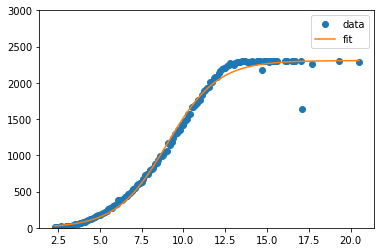

In [10]:
# Historical 5th Percentile

import pylab
from scipy.optimize import curve_fit
#from sklearn import preprocessing

def sigmoid(x, x0, k):
    #cap = 2300
    y = cap / (1 + np.exp(-k*(x-x0)))
    return y

xdata = pcurve5.index.values
ydata = pcurve5['wtc_ActPower_mean'].values
cap = np.max(pcurve5['wtc_ActPower_mean'].values)

popt, pcov = curve_fit(sigmoid, xdata, ydata)

pcurve5_x0 = popt[0]
pcurve5_k = popt[1]
pcurve5_cap = cap
print('x0:',pcurve5_x0)
print('k:',pcurve5_k)
print('Cap:',pcurve5_cap)

x = xdata
y = sigmoid(x,*popt)

pylab.plot(xdata, ydata, 'o', label='data')
pylab.plot(xdata,y, label='fit')
pylab.ylim(0, 3000)
pylab.legend(loc='best')
pylab.show()

In [11]:
def PowerCurve(wind, x0,k,cap):
    y = cap / (1 + np.exp(-k*(wind-x0)))
    return y

df['ExpectedEnergy_ref'] = df.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], 
                                                          x0=7.70514731, 
                                                          k=0.85471648, 
                                                          cap=2300), 
                                     axis = 1)
df['ExpectedEnergy_5th'] = df.apply(lambda x: PowerCurve(wind=x['wtc_AcWindSp_mean'], 
                                                          x0=pcurve5_x0, 
                                                          k=pcurve5_k,
                                                          cap=pcurve5_cap), 
                                     axis = 1)

In [12]:
# Make labels
# insipred by: https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns

def make_class(row):
    if row["wtc_ActPower_mean"] <= row["ExpectedEnergy_5th"]:
        return "1"
    else:
        return "0"

df["Underperformance"] = df.apply(lambda x: make_class(x), axis=1)
df['Underperformance'] = df['Underperformance'].astype(int)

percent = (df['Underperformance'].sum() / len(df))*100
print('Percent of Under Performance Data:',percent,"%")

Percent of Under Performance Data: 26.82522440112058 %


In [13]:
#Encode the labels (examples found on SKLearn website... need to find address)
le = preprocessing.LabelEncoder()
le.fit(list(df["Underperformance"].unique()))
# df_test["target"] = le.transform(df_test["Underperformance"])
df["target"] = le.transform(df["Underperformance"])
df = df.replace([np.inf, -np.inf], np.nan).dropna()



#Now the other variables used to train the model need to scaled. First, however, un-need variables need to be dropped.
y = df["target"]
# y2= df['target']



# df3 = df.drop(['wtc_GeOilTmp_mean',
#        'wtc_HubTemp_mean', 'wtc_NacelTmp_mean', 'wtc_ConvWTmp_mean',
#        'wtc_HydOilTm_mean', 'wtc_MainBTmp_mean', 'wtc_AlarmCde_endvalue',
#        'wtc_ScInOper_timeon', 'WindSpeed_adj','ExpectedEnergy_ref', 'ExpectedEnergy_25th',
#        'ExpectedEnergy_median', 'Underperformance','wtc_ActPower_mean','Fault_Type','Code', 
#         'Description', 'Fault_Type','Name','Derated','target'], axis=1)

# keepcols2 = ["Air_density", "wtc_ScInOper_timeon", "AirTC_3m_Avg", "WS_Thies_60m_Avg", 
#              "WS_ICEFREE_Avg", "BP_mbar_76m_Avg"]

keepcols = ['BoostedRef', 'WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

data = df[keepcols]


X = preprocessing.scale(data) 
# X2 = preprocessing.scale(df3)

data.columns

Index(['BoostedRef', 'WindSheer1', 'wtc_AcWindSp_mean', 'wtc_NacelPos_mean',
       'wtc_ScInOper_timeon', 'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg',
       'WS_ICEFREE_Avg', 'BP_mbar_76m_Avg', 'AirTC_3m_Avg', 'Icing',
       'Air_density'],
      dtype='object')

### Start KNN Classifier
Everything prior to this was data preperation. 

The goal of this classification model was to predict turbine under performance using a KNN approach. This information would be helpful to identify if a turbine is under performing using historical data. 

I did two things here. First, I ran a really simple KNN using different K values. Then I did a intensive grid search. My accuracy did not improve that much even though I trained and tested 30 different models. 

**Best Model: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}**


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
for x in range(1,11):
    K=x
    clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    clf.fit(X_train,y_train)
    p = clf.predict(X_test)
    a = accuracy_score(p,y_test)
    print('Accuracy of classifier with %d neighbors is: %.2f'%(K,a))
# I was getting 92% accuracy just through some basic KNN... I don't think we will get much better.

Accuracy of classifier with 1 neighbors is: 0.91
Accuracy of classifier with 2 neighbors is: 0.92
Accuracy of classifier with 3 neighbors is: 0.92
Accuracy of classifier with 4 neighbors is: 0.92
Accuracy of classifier with 5 neighbors is: 0.92
Accuracy of classifier with 6 neighbors is: 0.92
Accuracy of classifier with 7 neighbors is: 0.92
Accuracy of classifier with 8 neighbors is: 0.92
Accuracy of classifier with 9 neighbors is: 0.92
Accuracy of classifier with 10 neighbors is: 0.92


In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

k = list(range(1,6)) # search up to 5 neighbors
w = ['uniform', 'distance']
m = ['euclidean', 'minkowski', 'manhattan']
parameter_grid = {'n_neighbors': k, 'weights' : w, 'metric': m}

knn = KNeighborsClassifier()

g_seach = GridSearchCV(knn, param_grid=parameter_grid, scoring='accuracy')
g_seach.fit(X_train, y_train)
print("Best parameters set found on development set:")
print()
print(g_seach.best_params_)
print()

print("Detailed classification report:")
print()

y_true, y_pred = y_test, g_seach.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print(classification_report(y_true, y_pred))
print()
print("Accuracy:", acc)



Best parameters set found on development set:

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

Grid scores on development set:

Detailed classification report:

             precision    recall  f1-score   support

          0       0.93      0.97      0.95      7698
          1       0.91      0.81      0.86      2795

avg / total       0.93      0.93      0.93     10493


Accuracy: 0.9279519679786524


# Regression Task - KNN Regression to Predict Power Output

## Attempt 1: KNN Regression using non transformed data
Energy output is of critical importance to a wind farm. Our group wanted to determine if we could predict power output using KNN regression. We used the best classifier from the grid search to generate the hyper-parameters used by the regressor. The intial results were excellent. We acheived an R2 of 0.9317 indicating that the model could explain a little more than 93 percent of the variation found in the data.

In [29]:
y2 = df["wtc_ActPower_mean"]

# df3 = df.drop(['wtc_GeOilTmp_mean',
#        'wtc_HubTemp_mean', 'wtc_NacelTmp_mean', 'wtc_ConvWTmp_mean',
#        'wtc_HydOilTm_mean', 'wtc_MainBTmp_mean', 'wtc_AlarmCde_endvalue',
#        'wtc_ScInOper_timeon', 'WindSpeed_adj','ExpectedEnergy_ref', 'ExpectedEnergy_25th',
#        'ExpectedEnergy_median', 'Underperformance','wtc_ActPower_mean','Fault_Type','Code', 
#         'Description', 'Fault_Type','Name','Derated','target'], axis=1)

# keepcols2 = ["Air_density", "wtc_ScInOper_timeon", "AirTC_3m_Avg", "WS_Thies_60m_Avg", 
#              "WS_ICEFREE_Avg", "BP_mbar_76m_Avg"]

keepcols = ['WindSheer1',
            'wtc_AcWindSp_mean','wtc_NacelPos_mean','wtc_ScInOper_timeon', 
            'WS_Thies_80m_Avg', 'WS_Thies_60m_Avg', 'WS_ICEFREE_Avg',
           'BP_mbar_76m_Avg', 'AirTC_3m_Avg','Icing','Air_density']

data2 = df[keepcols]


# X2 = preprocessing.scale(data2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(data2, y2, test_size=0.2)

In [30]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

reg = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
# reg = KNeighborsRegressor()
reg.fit(X_train2, y_train2)
pred2 = reg.predict(X_test2)

reg.score(X_test2, y_test2)

0.9317481818344915

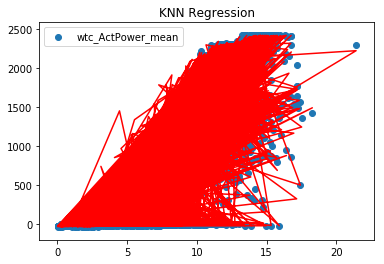

In [65]:
plt.scatter(x=X_test2["wtc_AcWindSp_mean"], y=y_test2)
plt.plot(X_test2["wtc_AcWindSp_mean"], pred2, 'r-')
plt.axis('tight')
plt.legend()
plt.title("KNN Regression")
plt.show()

## Attempt 2 - Implementation of PCA
PCA allowed us to reduce the features used in the KNN regression while maintaining a high R2 value. We did experience some interesting results. 

The first five principal components explaint over 99% of the variance in the data. However, the resulting KNN regression had an R2 of 0.8404. 

Using the first 6 principle components did not explain much more variance in the data, however, there was a large increase in model fit. The R2 increased to 0.9356 or a gain of 0.0952.

This means that PCA KNN Regression yielded slightly better results with roughly half of the number of featuers using the same hyper parameters. However, this additional increase in model performance is not worth the decrease in interpretability from the regular model.

In [85]:
# Using 5 Principal components
from sklearn.decomposition import PCA

pca2 = PCA(n_components=5) # there are 11 features
pca2.fit(data2)

pca_X_train2 = pca2.transform(X_train2)
pca_X_test2 = pca2.transform(X_test2)


print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

reg_pca = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
reg_pca.fit(pca_X_train2, y_train2)
pred_pca = reg_pca.predict(pca_X_test2)

reg_pca.score(pca_X_test2, y_test2)

[7.98850329e-01 1.94554726e-01 4.18285824e-03 1.87375758e-03
 4.60097880e-04]
0.9999217682499959


0.8404323116710646

In [86]:
#Using 6 principal components
from sklearn.decomposition import PCA

pca2 = PCA(n_components=6) # there are  11 features
pca2.fit(data2)

pca_X_train2 = pca2.transform(X_train2)
pca_X_test2 = pca2.transform(X_test2)


print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

reg_pca = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
reg_pca.fit(pca_X_train2, y_train2)
pred_pca = reg_pca.predict(pca_X_test2)

reg_pca.score(pca_X_test2, y_test2)

[7.98850329e-01 1.94554726e-01 4.18285824e-03 1.87375758e-03
 4.60097880e-04 7.32440830e-05]
0.9999950123330369


0.9355962752996375

# Another PCA implementation. Using regression for classificaiton... not wise, but left in for reference. 

# Do not include in final paper


In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2) # 12 components for 12 features
pca.fit(X)

pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)


print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))


[0.32639123 0.19147724]
0.5178684715850318


In [102]:
reg2 = KNeighborsRegressor(n_neighbors=5, metric='manhattan', weights='distance')
reg2.fit(pca_X_train, y_train)
pred2 = reg2.predict(pca_X_test)

for x in range(1,11):
    num = x / 10
    test = pd.DataFrame(pred2)
    test["Model"] = test[0].apply(lambda x: 1 if x > num else 0)


    holding = y_train.reset_index()

    comparison = test.join(holding)
    comparison["Correct"] = comparison["Model"] == comparison["target"]
    print("Accuracy for Regressor Model when cutoff is set at " + str(num) + " percent match:", 
          (comparison["Correct"].sum()/len(comparison["Correct"])) * 100, 
          " percent")

Accuracy for Regressor Model when cutoff is set at 0.1 percent match: 45.115791480034304  percent
Accuracy for Regressor Model when cutoff is set at 0.2 percent match: 52.492137615553226  percent
Accuracy for Regressor Model when cutoff is set at 0.3 percent match: 56.399504431525784  percent
Accuracy for Regressor Model when cutoff is set at 0.4 percent match: 60.173448965977315  percent
Accuracy for Regressor Model when cutoff is set at 0.5 percent match: 62.67988182597922  percent
Accuracy for Regressor Model when cutoff is set at 0.6 percent match: 64.76698751548652  percent
Accuracy for Regressor Model when cutoff is set at 0.7 percent match: 66.5014771752597  percent
Accuracy for Regressor Model when cutoff is set at 0.8 percent match: 67.5783855903936  percent
Accuracy for Regressor Model when cutoff is set at 0.9 percent match: 68.70294482035642  percent
Accuracy for Regressor Model when cutoff is set at 1.0 percent match: 72.67702277708949  percent
